# Семинар 7. Введение в итерационные методы

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.array(y, dtype=int)

In [2]:
X.shape

(70000, 784)

In [3]:
np.sqrt(X.shape[1])

28.0

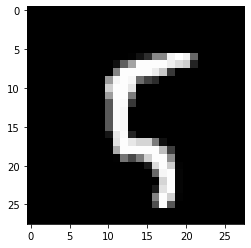

In [5]:
plt.imshow(X[100].reshape(28, 28),cmap="gray")

In [6]:
import scipy.sparse.linalg as spsplin
u, s, v = spsplin.svds(X - X.mean(axis=0)[None, :], k=2)

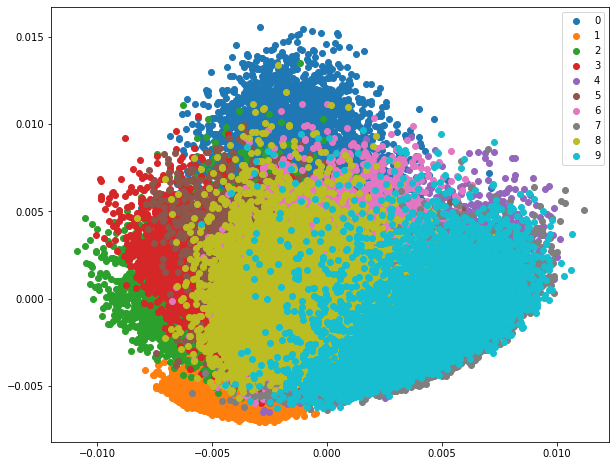

In [51]:
plt.figure(figsize=(10, 8))
for c in np.unique(y):
    plt.scatter(u[y == c, 0], u[y == c, 1], label="{}".format(c))
plt.legend()

In [12]:
import sklearn.manifold as sklman
tsne = sklman.TSNE(verbose=True)
X_2d = tsne.fit_transform(X[:4000, :])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.251s...
[t-SNE] Computed neighbors for 4000 samples in 25.183s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 487.387599
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.647079
[t-SNE] KL divergence after 1000 iterations: 1.362938


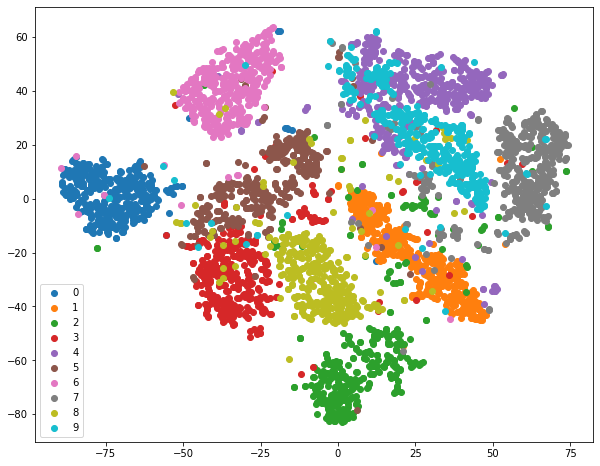

In [13]:
plt.figure(figsize=(10, 8))
for c in np.unique(y):
    plt.scatter(X_2d[y[:4000] == c, 0], X_2d[y[:4000] == c, 1], label="{}".format(c))
plt.legend()

## Рандомизированный метод вычисления SVD ([Halko et al, 2011](https://epubs.siam.org/doi/pdf/10.1137/090771806?casa_token=isi3yX3QdPEAAAAA:j-7Qk87vS0kjKqGMLYeX3xg4QxqqyM8s4wn-XGX-SLOS2BRChFDRTPX-x9Hf7ltfuZYg9xsA0zksw1U))

- Напомним постановку задачи

$$ A \approx U\Sigma V^\top, $$

где $A$ размера $m \times n$, $U$ размера $m \times k$ и $V$ размера $n \times k$.

- Мы уже показывали ранее, что сложность вычисления приближения ранга $k$ составляет $O(mnk)$
- Как можно уменьшить эту сложность?

- Пусть мы знаем ортогональную матрицу $Q$ размера $m \times k$ такую что

$$A \approx Q Q^{\top}A $$

- Другими словами столбцы $Q$ являются базисом в пространстве столбцом матрицы $A$
- Тогда следующие детерминированные шаги помогут вычислить факторы $U$, $\Sigma$ и $V$, соответствующие факторам из SVD для матрицы $A$
    - Сформировать $k \times n$ матрицу $B = Q^{\top}A$
    - Вычислить SVD от матрицы $B = \hat{U}\Sigma V^{\top}$ небольшого размера
    - Обновить левые сингулярные векторы $U = Q\hat{U}$
    
- Если $k \ll \min(m, n)$ тогда эти шаги можно выполнить быстро
- Если $Q$ образует точный базис в пространстве столбцов матрицы $A$, тогда $U$, $\Sigma$ и $V$ также являются точными факторами из SVD исходной матрицы!
- Итак, как сгенерировать матрицу $Q$?

### Рандомизированное приближение базиса в пространсте столбцов матрицы $A$

- Основной подход
    - Сгенерировать $k + p$ случайных гауссовых векторов размерности $m$ и сформировать матрицу $G$
    - Вычислить $Y = AG$
    - Вычислить QR разложение $Y$ и использовать матрицу $Q$ как аппроксимацию базиса
- Параметр $p$ называется параметров сэмплирования и необходим для повышения точности приближения ведущих $k$ левых сингулярных вектров в дальнейших преобразованиях
- Вычисление $Y$ может выполнено параллельно
- Нам нужна только функция умножения матрицы на вектор, а не сами элементы матрицы – вспомните про концепцию чёрного ящика!
- Вместо гауссовой случайной матрицы можно использовать более структурированные, но по-прежнему случайные матрицы, что позволит выполнить умножение на $A$ быстрее

Error from randomized SVD 913.5208499858654
Error from exact SVD 887.8522565790656


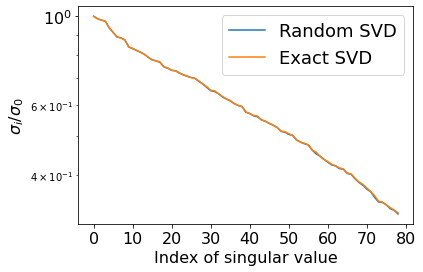

In [18]:
import numpy as np

n = 1000
k = 100
m = 200
# Lowrank matrix
A = np.random.randn(n, k)
B = np.random.randn(k, m)
A = A @ B

# Random matrix
# A = np.random.randn(n, m)

def randomized_svd(A, rank, p):
    m, n = A.shape
    G = np.random.randn(n, rank + p)
    Y = A @ G
    Q, _ = np.linalg.qr(Y)
    B = Q.T @ A
    u, S, V = np.linalg.svd(B)
    U = Q @ u
    return U, S, V

rank = 79
p = 20
U, S, V = randomized_svd(A, rank, p)
print("Error from randomized SVD", np.linalg.norm(A - U[:, :rank] * S[None, :rank] @ V[:rank, :]))
plt.semilogy(S[:rank] / S[0], label="Random SVD")
u, s, v = np.linalg.svd(A)
print("Error from exact SVD", np.linalg.norm(A - u[:, :rank] * s[None, :rank] @ v[:rank, :]))
plt.semilogy(s[:rank] / s[0], label="Exact SVD")
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
_ = plt.xlabel("Index of singular value", fontsize=16)

In [19]:
import scipy.sparse.linalg as spsplin
# !pip install fbpca
# More details about Facebook package for computing randomized SVD is here: https://research.fb.com/blog/2014/09/fast-randomized-svd/ 
import fbpca
n = 1000
m = 200
A = np.random.randn(n, m)
k = 10
p = 10
%timeit spsplin.svds(A, k=k)
%timeit randomized_svd(A, k, p)
%timeit fbpca.pca(A, k=k, raw=False) 

18.4 ms ± 3.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.15 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.39 ms ± 699 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Теорема сходимости

Усреднённая ошибка аппроксимации с помощью предложенного алгоритма, где $k$ ранг аппроксимации и $p$ параметр сэмплирования:

- во фробениусовой норме

$$ \mathbb{E}\|A - QQ^{\top}A \|_F \leq \left( 1 + \frac{k}{p-1} \right)^{1/2}\left( \sum_{j=k+1}^{\min(m, n)} \sigma^2_j \right)^{1/2}  $$

- в спектральной норме

$$ \mathbb{E}\|A - QQ^{\top}A \|_2 \leq \left( 1 + \sqrt{\frac{k}{p-1}} \right)\sigma_{k+1} + \frac{e\sqrt{k+p}}{p}\left( \sum_{j=k+1}^{\min(m, n)} \sigma^2_j \right)^{1/2} $$

Матожидание вычисляется по распределению, из которого генерируется случайная матрица $G$ в методе выше.

Сравните эти оценки с результатом теоремы Экхарта-Янга. Являются ли эти оценки точными?



## Повышение точности в рандомизированном методе вычисления SVD

- Основная идея: степенной метод
- Если $A = U \Sigma V^\top$, тогда $A^{(q)} = (AA^{\top})^qA = U \Sigma^{2q+1}V^\top $, где $q$ некоторое небольшое натуральное число, например 1 или 2
- Тогда мы сэмплируем базис для $A^{(q)}$ а не для $A$

$$ Y = (AA^{\top})^qAG \qquad Q, R = \mathtt{qr}(Y) $$

- Основная причина: если сингулярные значения $A$ убывали медленно, то сингулярные значения $A^{(q)}$ будут убывать быстрее

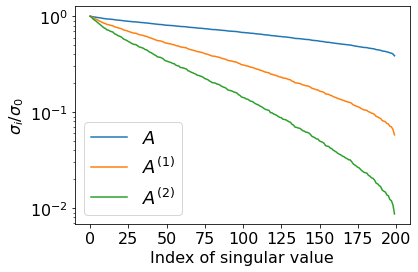

In [21]:
n = 1000
m = 200
A = np.random.randn(n, m)
s = np.linalg.svd(A, compute_uv=False)
Aq = A @ A.T @ A
sq = np.linalg.svd(Aq, compute_uv=False)
Aqq = A @ A.T @ A @ A.T @ A
sqq = np.linalg.svd(Aqq, compute_uv=False)
plt.semilogy(s / s[0], label="$A$")
plt.semilogy(sq / sq[0], label="$A^{(1)}$")
plt.semilogy(sqq / sqq[0], label="$A^{(2)}$")
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
_ = plt.xlabel("Index of singular value", fontsize=16)

### Потеря точности из-за ошибок округления

- Наивное формирование $A^{(q)}$ приводит к росту числа обусловленности и потере точности

**Q:** как можно исправить эту проблему?

**A:** последовательная ортогонализация!

Error from randomized SVD 287.3392388811401
Error from more accurate randomized SVD 250.843795982777
Error from exact SVD 249.95218605165576


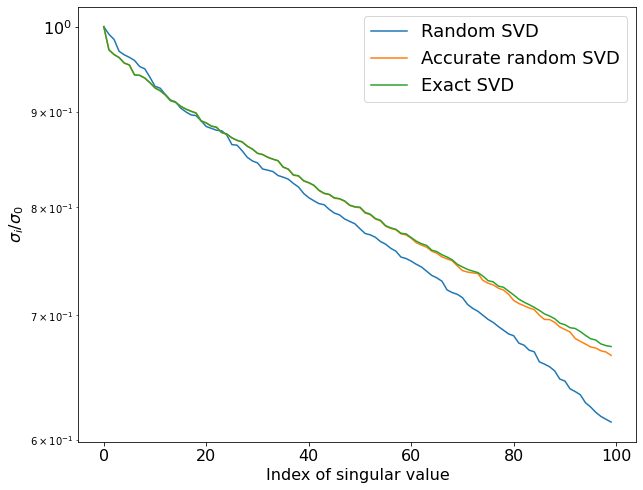

In [25]:
def more_accurate_randomized_svd(A, rank, p, q):
    m, n = A.shape
    G = np.random.randn(n, rank + p)
    Y = A @ G
    Q, _ = np.linalg.qr(Y)
    for i in range(q):
        W = A.T @ Q
        W, _ = np.linalg.qr(W)
        Q = A @ W
        Q, _ = np.linalg.qr(Q)
    B = Q.T @ A
    u, S, V = np.linalg.svd(B)
    U = Q @ u
    return U, S, V

n = 1000
m = 200
A = np.random.randn(n, m)

rank = 100
p = 20
U, S, V = randomized_svd(A, rank, p)
print("Error from randomized SVD", np.linalg.norm(A - U[:, :rank] * S[None, :rank] @ V[:rank, :]))

plt.figure(figsize=(10, 8))
plt.semilogy(S[:rank] / S[0], label="Random SVD")

Uq, Sq, Vq = more_accurate_randomized_svd(A, rank, p, 5)
print("Error from more accurate randomized SVD", np.linalg.norm(A - Uq[:, :rank] * Sq[None, :rank] @ Vq[:rank, :]))


plt.semilogy(Sq[:rank] / Sq[0], label="Accurate random SVD")

u, s, v = np.linalg.svd(A)
print("Error from exact SVD", np.linalg.norm(A - u[:, :rank] * s[None, :rank] @ v[:rank, :]))
plt.semilogy(s[:rank] / s[0], label="Exact SVD")
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
_ = plt.xlabel("Index of singular value", fontsize=16)

In [26]:
%timeit spsplin.svds(A, k=k)
%timeit fbpca.pca(A, k=k, raw=False)
%timeit randomized_svd(A, k, p) 
%timeit more_accurate_randomized_svd(A, k, p, 1)
%timeit more_accurate_randomized_svd(A, k, p, 2)
%timeit more_accurate_randomized_svd(A, k, p, 5)

13.7 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.14 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.07 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.35 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.88 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.7 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Теорема сходимости

Представленный выше метод обеспечивает следующую верхнюю границу

$$ \mathbb{E}\|A - QQ^{\top}A \|_2 \leq \left[\left( 1 + \sqrt{\frac{k}{p-1}} \right)\sigma^{2q+1}_{k+1} + \frac{e\sqrt{k+p}}{p}\left( \sum_{j=k+1}^{\min(m, n)} \sigma^{2(2q+1)}_j \right)^{1/2}\right]^{1/(2q+1)} $$

Рассмотрите наихудший случай, когда в данной матрице нет малоранговой структуры.

**Q:** какова степень субоптимальности по сравнению с теоремой Экхарта-Янга? 

### Резюме по рандомизированному методу для вычисления SVD

- Эффективный метод получения приближённого SVD
- Простой в реализации
- Его можно расширить до однопроходного метода, когда матрица $ A $ нужна только для построения $ Q $
- Требуется только функция умножения данной матрицы на вектор

## Спектральная кластеризация графа

- Связь задачи о рабиении вершин графа с собственными значениями
- Формализация задачи

## Спектральное разбиение графа

- Идея спектрального разбиения восходит к работам Мирослава Фидлера, который изучал связность графов ([статья](https://dml.cz/bitstream/handle/10338.dmlcz/101168/CzechMathJ_23-1973-2_11.pdf)).

- Нам нужно разбить вершинеы графа на 2 множества

- Рассмотрим метки вершин +1/-1 и **функцию потерь**

$$E_c(x) = \sum_{j} \sum_{i \in N(j)} (x_i - x_j)^2, \quad N(j) \text{ обозначает множество соседей вершины } j. $$

Нам нужно сбалансированное разбиение, поэтому

$$\sum_i x_i =  0 \quad \Longleftrightarrow \quad x^\top e = 0, \quad e = \begin{bmatrix}1 & \dots & 1\end{bmatrix}^\top,$$

и поскольку мы ввели метки +1/-1, то выполнено

$$\sum_i x^2_i = n \quad \Longleftrightarrow \quad \|x\|_2^2 = n.$$

## Лапласиан графа

Функция потерь $E_c$ может быть записана в виде (проверьте почему)

$$E_c = (Lx, x)$$

где $L$ – **Лапласиан графа**, который определяется как симметричная матрица с элементами

$$L_{ii} = \mbox{степень вершины $i$},$$

$$L_{ij} = -1, \quad \mbox{если $i \ne j$  и существует ребро},$$

и $0$ иначе.

- Строчные суммы в матрице $L$ равны нулю, поэтому существует собственное значение $0$, которое даёт собственный вектор из всех 1.
- Собственные значения неотрицательны (почему?).

## Разбиение как задача оптимизации

- Минимизация $E_c$ с упомянутыми ограничениями приводит к разбиению, которое сохраняет разбиение сбалансированным

- Теперь мы запишем релаксацию целочисленной задачи квадратичного программирования в форме непрерывной задачи квадратичного программирования

$$E_c(x) = (Lx, x)\to \min_{\substack{x^\top e =0, \\ \|x\|_2^2 = n}}$$

## Вектор Фидлера

- Решение этой задачи минимизации – собственный вектор матрицы $L$, соответствующий **второму** минимальному собственному значению (он называется вектором Фидлера)
- В самом деле,

$$
    \min_{\substack{x^\top e =0, \\ \|x\|_2^2 = n}} (Lx, x) = n \cdot \min_{{x^\top e =0}} \frac{(Lx, x)}{(x, x)} = n \cdot \min_{{x^\top e =0}} R(x), \quad R(x) \text{ отношение Релея}
$$

- Поскольку $e$ – собственный вектор, соответствующий наименьшему собственному значению, то на подпространстве $x^\top e =0$ мы получим второе минимальное собственное значение.

- Знак $x_i$ обозначает разбиение графа.

- Осталось понять, как вычислить этот вектор. Мы знаем про степенной метод, но он ищет собственный вектор для максимального по модулю собственного значения.


Number of vertices = 34
Number of edges = 78


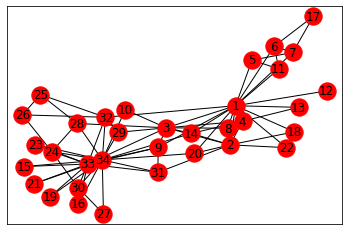

In [27]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
kn = nx.read_gml('karate.gml')
print("Number of vertices = {}".format(kn.number_of_nodes()))
print("Number of edges = {}".format(kn.number_of_edges()))
nx.draw_networkx(kn, node_color="red") #Draw the graph

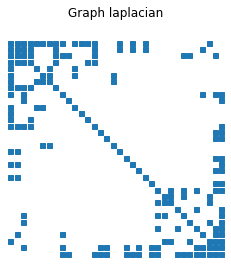

The 2 smallest eigenvalues = [-3.63719012e-15  4.68525227e-01]


In [28]:
Laplacian = nx.laplacian_matrix(kn).asfptype()
plt.spy(Laplacian, markersize=5)
plt.title("Graph laplacian")
plt.axis("off")
plt.show()
eigval, eigvec = spsplin.eigsh(Laplacian, k=2, which="SM")
print("The 2 smallest eigenvalues =", eigval)

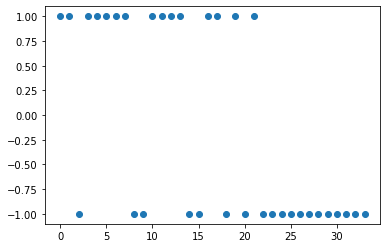

Sum of elements in Fiedler vector = 7.355227538141662e-16


In [29]:
plt.scatter(np.arange(len(eigvec[:, 1])), np.sign(eigvec[:, 1]))
plt.show()
print("Sum of elements in Fiedler vector = {}".format(np.sum(eigvec[:, 1].real)))

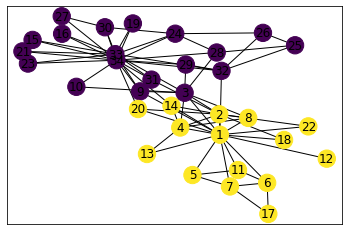

In [30]:
nx.draw_networkx(kn, node_color=np.sign(eigvec[:, 1]))